# Declarations

Please run below to start up.

In [28]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [29]:
class Road:
    def __init__(self, city, numOfCell=10, introRate=2, remvRate=2, carRateDist = {}, direction = (0,1),moveProb=0.5, startPos = (0,0),interval =0.001,totalTime = 1000,name=''):
        #int numOfCell, int introRate, int remvRate, int index
        self.__introRate = introRate
        self.__remvRate = remvRate
        self.carRateDist = carRateDist 
        self.allCars = [] #cars in this road
        self.numOfCell = numOfCell
        self.passCar = 0 # number of the passing cars
        self.conflict = 0
        self.direction = direction
        self.startPos = startPos
        self.endPos = (startPos[0]+self.direction[0]*(self.numOfCell-1), startPos[1]+self.direction[1]*(self.numOfCell-1))
        #self.cell = {}  #cells in this road
        self.city = city
        self.time_sum_car = 0
        self.density = 0
        self.J = 0
        self.interval = interval
        self.totalTime = totalTime
        self.name = name
        self.moveProb = moveProb
        
        ###################################################################
        self.cells = []
        for i in range(self.numOfCell):
            self.cells.append((self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i))
        
        for point in self.cells:
            if point in self.city.map:
                if self.city.map[point] == 1:
                    for road in self.city.roads:
                        if point in road.cells:
                            self.city.crossRoad.update({point:(road, self)})
            else:
                self.city.map[point] = 1
        ##################################################################
        
        #for i in range(self.numOfCell):
            #self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] = 1
        
    def introCar(self):
        # introduce a new car to this road
        if ((random.random() < self.__introRate*self.interval) and(self.city.map[self.startPos] == 1)):
            self.city.map[self.startPos] = 2
            carRate = abs(np.random.normal(self.carRateDist['mean'],self.carRateDist['var']**(0.5)))
            newCar = Car(self, prob=self.moveProb, interval = self.interval,expClockRate= carRate)
            #self.allCars.insert(0, newCar)
            self.allCars.append(newCar)
            
    def remvCar(self):
        # remove the car in the last cell of this road
        if ((random.random() < self.__remvRate*self.interval)and (self.city.map[self.endPos] == 2)):
            self.city.map[self.endPos] = 1
            self.allCars.pop(0)
            self.passCar += 1
            
    def showCar(self):
        for i in range(self.numOfCell):
            if self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] == 1:
                print(" | "+" ",end="")
            else:
                print(" | "+"*",end="")
        print(" |\n")
    def calculateRate(self):
        self.density = self.time_sum_car/(self.totalTime/self.interval*self.numOfCell)
        self.J = self.passCar / self.totalTime
        

        

In [30]:
class Car:
    def __init__(self, road, position=0, expClockRate=3, prob=0.5,interval =0.001):
        #int position, int expClockRate, float prob, int index (which road)
        self.__position = (road.startPos[0]+road.direction[0]*position, road.startPos[1]+road.direction[1]*position)
        self.__expClockRate = expClockRate
        self.__prob = prob
        self.__road = road
        self.accident = 0
        self.interval = interval
    def moveForward(self):
        if(self.__position==self.__road.endPos):
            return "end"
        if (random.random() < self.__expClockRate*self.interval) and (random.random() < self.__prob):
            # expo & not broken
            if (self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 1): # next cell is empty
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])
                self.__road.city.map[self.__position] = 2
            elif(self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 4) and \
            self.__road.city.map[(self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)] == 1:#green light
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)
                self.__road.city.map[self.__position] = 2
            else:
                return "conflict"
                
        return "move"
    ##################################################################
    def moveForwardWithCRA(self):
        if(self.__position == self.__road.endPos):
            return "end"
        if (random.random() < self.__expClockRate*self.interval) and (random.random() < self.__prob)and (self.accident == 0):
            # expo & not broken
            if self.__position in self.__road.city.crossRoad:
                self.__road.allCars.pop(self.__road.allCars.index(self))
                if random.random() > 0.5:
                    self.__road = self.__road.city.crossRoad[self.__position][0]
                else:
                    self.__road = self.__road.city.crossRoad[self.__position][1]
                for car in self.__road.allCars:
                    if self.__road.direction > (0,0):
                        if self.__position > car.__position:
                            self.__road.allCars.insert(self.__road.allCars.index(car), self)
                            break
                    else:
                        if self.__position < car.__position:
                            self.__road.allCars.insert(self.__road.allCars.index(car), self)
                            break
                    
                    
############################ move ###############################            

            
            if (self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 1): # next cell is empty
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])
                self.__road.city.map[self.__position] = 2
            elif(self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 4) and \
            self.__road.city.map[(self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)] == 1:#green light
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0]*2, self.__position[1]+self.__road.direction[1]*2)
                self.__road.city.map[self.__position] = 2
            else:
                return "conflict"
############################ move ###############################            
            
            
            if ((self.__position[0]+2*self.__road.direction[0], self.__position[1]+2*self.__road.direction[1]) in self.__road.city.crossRoad) \
            or ((self.__position[0]-self.__road.direction[0], self.__position[1]-self.__road.direction[1]) in self.__road.city.crossRoad) \
            or ((self.__position[0]-2*self.__road.direction[0], self.__position[1]-2*self.__road.direction[1]) in self.__road.city.crossRoad):
                self.__road.city.map[self.__position] = 10
            if self.__position in self.__road.city.crossRoad:
                self.__road.city.map[self.__position] = 10
            return "move"
        
        elif (self.accident == 1):
            self.__road.city.map[self.__position] = 20

    ##################################################################

In [31]:
class City:
    def __init__(self, acciProb=0.05,l=100, w=100,totalTime = 1000,interval = 0.001,name='Berkeley'):
        self.l = l
        self.w = w
        self.map = {(i,j):0 for i in range(-self.l,-self.l) for j in range(-self.w,self.w)} 
        self.roads=[]
        self.totalTime = totalTime
        self.interval = interval
        self.name = name
        self.J = 0
        self.density = 0
        self.time_sum_car = 0
        self.numOfCell = 0
        self.passCar = 0
        self.acciProb = acciProb
        
        
        ##################################################################
        self.crossRoad = {}
        self.accCars = []
        ##################################################################

    def showCity(self):
        rx, ry = [],[]
        cx, cy = [],[]
        lx, ly = [],[]
        gx, gy = [],[]
        crx, cry = [],[]
        accx = []
        accy = []
        for i in self.map:
            if self.map[i] != 0:
                rx.append(i[0])
                ry.append(i[1])
            if self.map[i] == 2:
                cx.append(i[0])
                cy.append(i[1])
            elif self.map[i] == 3:
                lx.append(i[0])
                ly.append(i[1])
            elif self.map[i] == 4:
                gx.append(i[0])
                gy.append(i[1])
            elif self.map[i] == 10:
                crx.append(i[0])
                cry.append(i[1])
            elif self.map[i] == 20:
                accx.append(i[0])
                accy.append(i[1])
                
            
        plt.plot(rx, ry, marker="o",color="navy",linestyle=" ",markersize=2)
        plt.plot(cx, cy, marker="*",color="y",linestyle=" ")
        plt.plot(lx, ly, marker="s",color="r",linestyle=" ")
        plt.plot(gx, gy, marker="s",color="lightgreen",linestyle=" ")
        plt.plot(crx, cry, marker="H",color="orange",linestyle=" ")
        ax.plot(accx, accy, marker="x",color="pink",linestyle=" ")
        plt.show()
        
    def showCitySub(self):
        ax.clear()
        rx = []
        ry = []
        cx = []
        cy = []
        lx = []
        ly = []
        gx = []
        gy = []
        crx = []
        cry = []
        accx = []
        accy = []
        for i in self.map:
            if self.map[i] != 0:
                rx.append(i[0])
                ry.append(i[1])
            if self.map[i] == 2:
                cx.append(i[0])
                cy.append(i[1])
            elif self.map[i] == 3:
                lx.append(i[0])
                ly.append(i[1])
            elif self.map[i] == 4:
                gx.append(i[0])
                gy.append(i[1])
            elif self.map[i] == 10:
                crx.append(i[0])
                cry.append(i[1])
            elif self.map[i] == 20:
                accx.append(i[0])
                accy.append(i[1])
        ax.plot(rx, ry, marker="o",color="navy",linestyle=" ",markersize=8)
        ax.plot(cx, cy, marker="*",color="y",linestyle=" ")
        ax.plot(lx, ly, marker="s",color="r",linestyle=" ")
        ax.plot(gx, gy, marker="s",color="lightgreen",linestyle=" ")
        ax.plot(crx, cry, marker="h",color="orange",linestyle=" ")
        ax.plot(accx, accy, marker="x",color="pink",linestyle=" ")
        fig.canvas.draw()
    
    def createRoad(self,numOfCell=10, introRate=2, remvRate=2,carRate = {'mean':5,'var':2},moveProb=0.5, direction = (0,1), startPos = (0,0),name = ''):
        newRoad = Road(self, numOfCell=numOfCell, introRate=introRate, remvRate=remvRate, direction = direction, \
                       startPos = startPos,moveProb=moveProb,carRateDist =carRate, interval = self.interval,totalTime = self.totalTime, name = name)
        self.roads.append(newRoad)
        self.numOfCell += newRoad.numOfCell
    def introCar(self):
        for road in self.roads:
            road.introCar()
            
    def remvCar(self):
        self.passCar = 0
        for road in self.roads:
            road.remvCar()
            self.passCar += road.passCar
    def moveCar(self):
        for road in self.roads:
            for car in road.allCars:
                ret = car.moveForward()
                if ret =="conflict":
                    road.conflict += 1
                    
    ##################################################################               
    def moveCarWithCRA(self):
        for road in self.roads:
            for car in road.allCars:
                ret = car.moveForwardWithCRA()
                if ret =="conflict":
                    road.conflict += 1
                    
        if random.random() < self.acciProb:
            accRoad = random.choice(self.roads)
            if accRoad.allCars != []:
                accCar = random.choice(accRoad.allCars)
                self.accCars.append(accCar)
                accCar.accident = 1
            
        if (random.random() < 0.3) and (self.accCars != []):
            fixCar = random.choice(self.accCars)
            self.accCars.pop(self.accCars.index(fixCar))
            fixCar.accident = 0
    ##################################################################
                    
    
    def Time_sum_car(self):
        for road in self.roads:
            road.time_sum_car += len(road.allCars)
    def calculateRate(self):
        for road in self.roads:
            road.calculateRate()
            self.time_sum_car += road.time_sum_car
        self.density = self.time_sum_car/(self.totalTime/self.interval*self.numOfCell)
        self.J = self.passCar / self.totalTime
    def light(self, position):
        if random.random < 0.5:
            self.City.map[position] = 3
        else:
            self.City.map[position] = 1
            
    def crossRoadLight(self, position1, position2):
        if random.random() < 0.5:
            self.map[position1] = 3
            self.map[position2] = 1
        else:
            self.map[position1] = 1
            self.map[position2] = 3
            
    def crossRoadLight2(self, position1, position2, position3, position4, counter): #1=3, 2=4
        if(counter % 50 <= 24):
            self.map[position1] = 3
            self.map[position2] = 4
            self.map[position3] = 3
            self.map[position4] = 4
        else:
            self.map[position1] = 4
            self.map[position2] = 3
            self.map[position3] = 4
            self.map[position4] = 3
    def freshMap(self):
        del(self.roads[:])
        self.numOfCell = 0
        self.roads=[]
        
        ##################################################################
        self.crossRoad = {}
        ##################################################################


        #self.map = {i:0 for i in self.map}
        self.map={}

# Starter

Run the cell below after running the declaritions above. In this cell, you can customize any parameter you want.

In [32]:
carRateMean = widgets.FloatSlider(value=3.0,min=0.1, max=100.0, step=0.1, description='carRateMean: ')
carRateVar = widgets.FloatSlider(value=3.0,min=0, max=100.0, step=0.1, description='carRateVariance: ')

carMoveProb = widgets.FloatSlider(value=0.5,min=0.0, max=1.0,step =0.001, description='moveProb:')
acciProb = widgets.FloatSlider(value=0.05,min=0.0, max=1.0,step =0.001, description='acciProb:')

numOfCell = widgets.IntSlider(value=10,min=10, max=100, step=1, description='numOfCell: ')
introRate = widgets.FloatSlider(value=3.0,min=0.1, max=100.0, step=0.1, description='introRate: ')
remvRate = widgets.FloatSlider(value=3.0,min=0.1, max=100.0, step=0.1, description='remvRate: ')

ui = widgets.VBox([carRateMean, carRateVar, carMoveProb, acciProb, numOfCell, introRate, remvRate])

def f(carRateMean, carRateVar, carMoveProb, acciProb, numOfCell, introRate, remvRate):
    print('Now on our roads: \n'+' The speed of the cars is a normal distribution with mean '+str(carRateMean),'and variance '+str(carRateVar)+'\n', 'The probability that each of the cars move is '+str(carMoveProb)+', and with the probability of '+str(acciProb)+' that each car goes into accident.\n', 'At the same time, there are '+str(numOfCell)+' cars at most on our roads.\n', 'The cars go into the roads at a rate of '+str(introRate)+'\n', 'The cars leave the roads at a rate of '+str(remvRate)+'\n')
    return(carRateMean,carRateVar, carMoveProb, numOfCell, introRate, remvRate)

out = widgets.interactive_output(f, {'acciProb':acciProb,'carRateVar': carRateVar,'remvRate': remvRate, 'introRate': introRate, 'numOfCell': numOfCell, 'carMoveProb':carMoveProb , 'carRateMean': carRateMean})

print('Please use the sliders below to adjust the parameters. They are: carRateMean, carRateVar, carMoveProb, acciProb, numOfCell, introRate, remvRate')

display(ui, out)

# print(carRate.value)

# def on_value_change(change):
#     with out:
#         print(change['new'])
#     return change['new']

# print(numOfCell.observe(on_value_change, names='value'))

print("Now we are ready for the simulations.")

Please use the sliders below to adjust the parameters. They are: carRateMean, carRateVar, carMoveProb, acciProb, numOfCell, introRate, remvRate


Now we are ready for the simulations.


# Simulation
First, let's see the road condition for a discrete road.

<IPython.core.display.Javascript object>


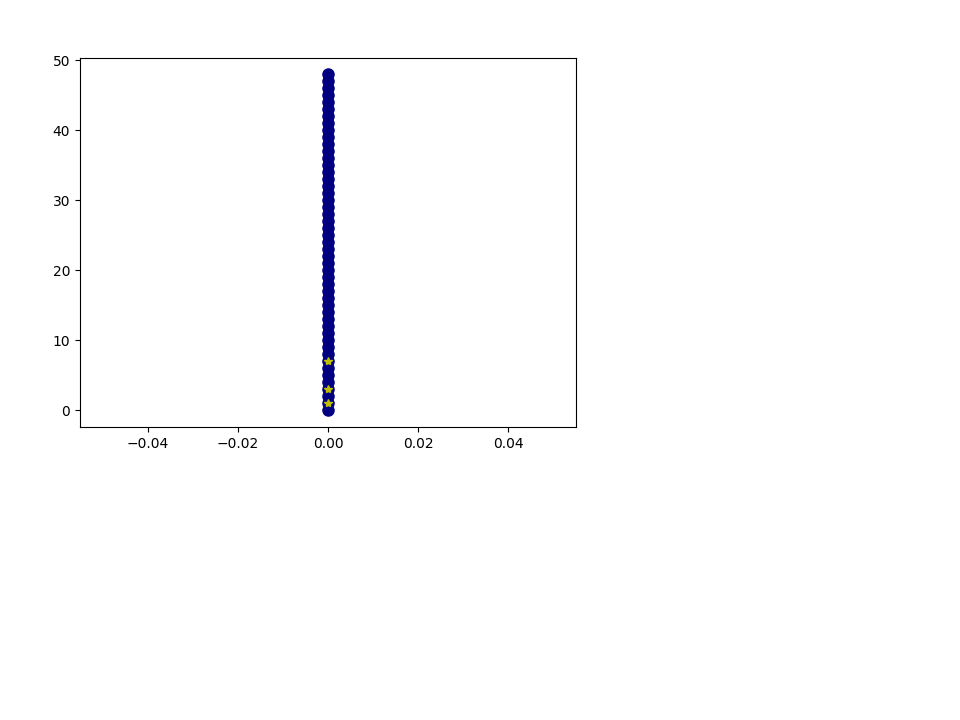

KeyboardInterrupt: 

In [33]:
%matplotlib notebook
TOTAL_TIME = 100
interval = 0.01

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

SF = City(acciProb=acciProb.value,totalTime=TOTAL_TIME, interval=interval, name = 'SF')
SF.freshMap()
dist = {'mean':carRateMean.value,'var':carRateVar.value}
SF.createRoad(numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
startTime = 0
Stop = False
currentTime = startTime - interval

fig.show()
fig.canvas.draw()

while not Stop:
    currentTime = currentTime + interval
    if currentTime > TOTAL_TIME:
        Stop = True
    SF.introCar()
    SF.remvCar()
    #SF.moveCar()
    ###########################
    SF.moveCarWithCRA()
    ###########################
    SF.showCitySub()
    time.sleep(0.05)
#     print (len(SF.roads[0].allCars),end=' ')

What about crossroads? Let's see what will happen if there are two roads coincident with each other.

<IPython.core.display.Javascript object>


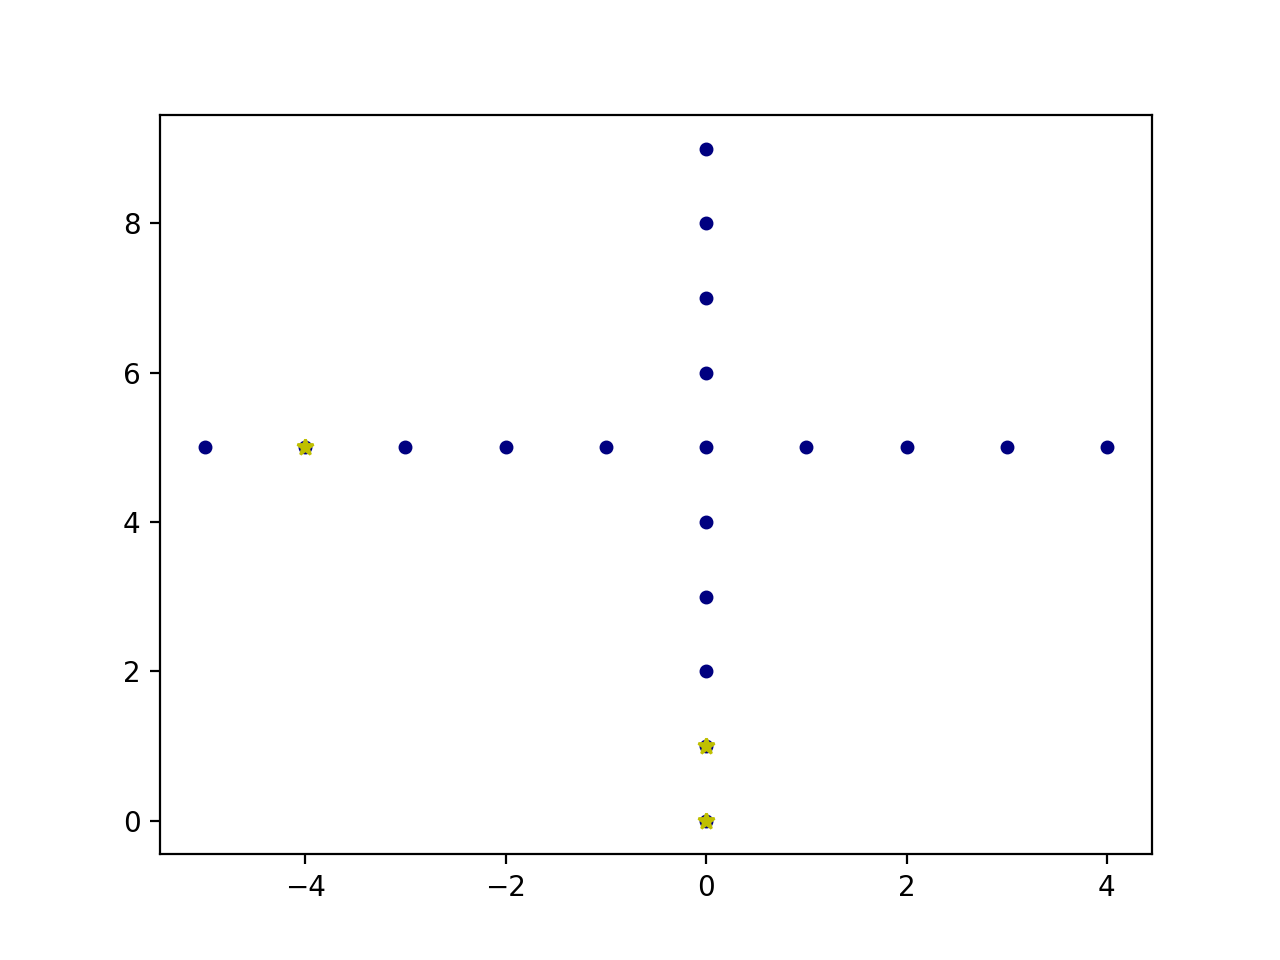

In [45]:
%matplotlib notebook
TOTAL_TIME = 1
interval = 0.01

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
dist = {'mean':carRateMean.value,'var':carRateVar.value}
SF = City(acciProb=acciProb.value,totalTime=TOTAL_TIME, interval=interval, name = 'SF')
SF.freshMap()
SF.createRoad(numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=carRate.value)
SF.createRoad(direction = (1,0), startPos = (-int(numOfCell.value/2),int(numOfCell.value/2)), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
startTime = 0
Stop = False
currentTime = startTime - interval

fig.show()
fig.canvas.draw()

while not Stop:
    currentTime = currentTime + interval
    if currentTime > TOTAL_TIME:
        Stop = True
    SF.introCar()
    SF.remvCar()
    #SF.moveCar()
    ###########################
    SF.moveCarWithCRA()
    ###########################
    SF.showCitySub()
    time.sleep(0.05)
#     print (len(SF.roads[0].allCars),end=' ')

<IPython.core.display.Javascript object>


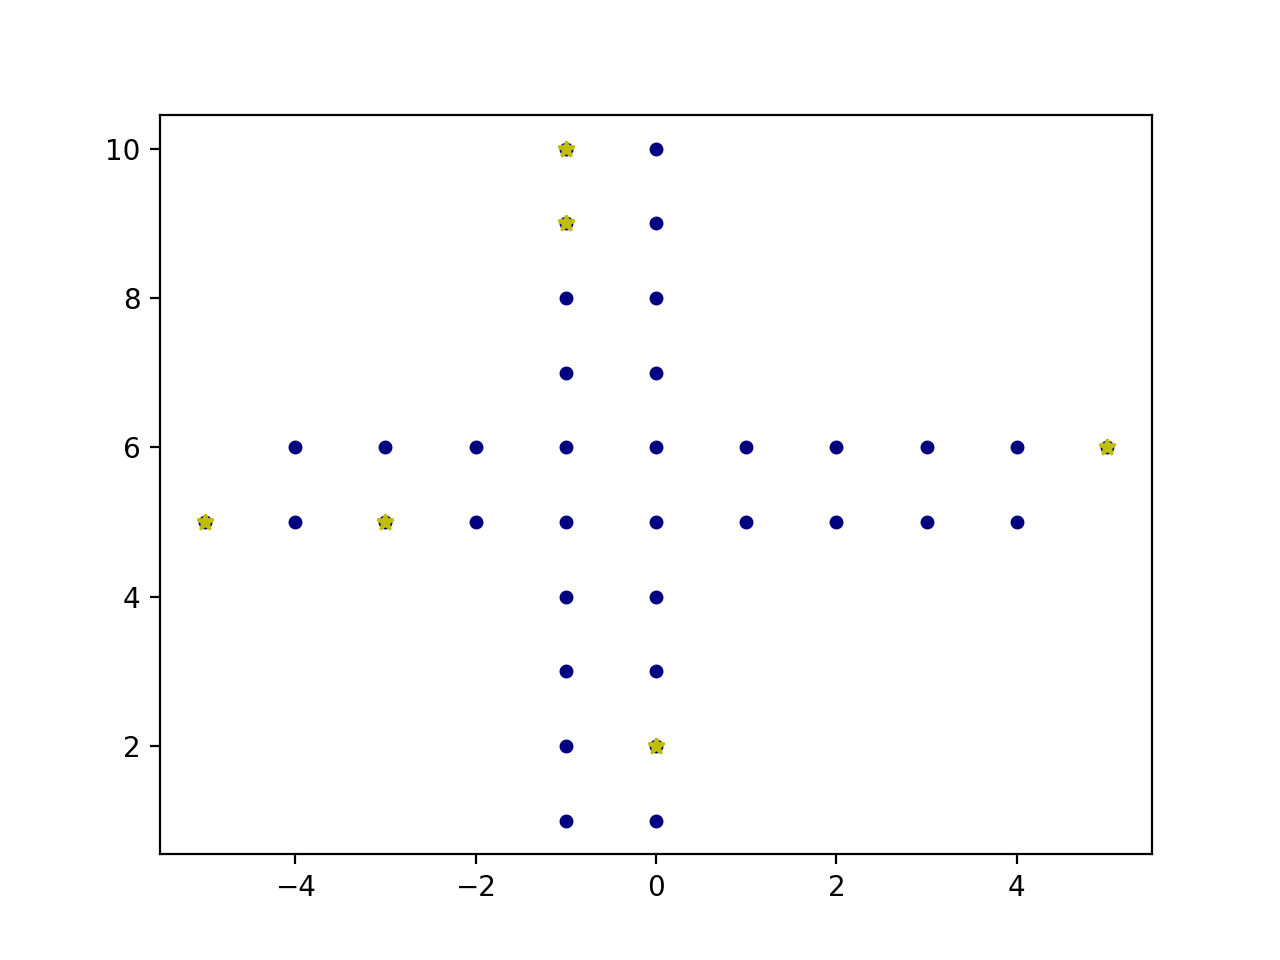

In [36]:
%matplotlib notebook
TOTAL_TIME = 1
interval = 0.01

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
dist = {'mean':carRateMean.value,'var':carRateVar.value}
SF = City(acciProb=acciProb.value,totalTime=TOTAL_TIME, interval=interval, name = 'SF')
SF.freshMap()
SF.createRoad(direction = (0,1),startPos = (0,1),numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (1,0), startPos = (-int(numOfCell.value/2),int(numOfCell.value/2)), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (0,-1),startPos = (-1,int(numOfCell.value)),numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (-1,0), startPos = (int(numOfCell.value/2),int(numOfCell.value/2)+1), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)

startTime = 0
Stop = False
currentTime = startTime - interval

fig.show()
fig.canvas.draw()

while not Stop:
    currentTime = currentTime + interval
    if currentTime > TOTAL_TIME:
        Stop = True
    SF.introCar()
    SF.remvCar()
    #SF.moveCar()
    ###########################
    SF.moveCarWithCRA()
    ###########################
    SF.showCitySub()
    time.sleep(0.05)

Since there is a crossroad and we don't have police officers to help keeping the order. We decided to add traffic lights. 

<IPython.core.display.Javascript object>


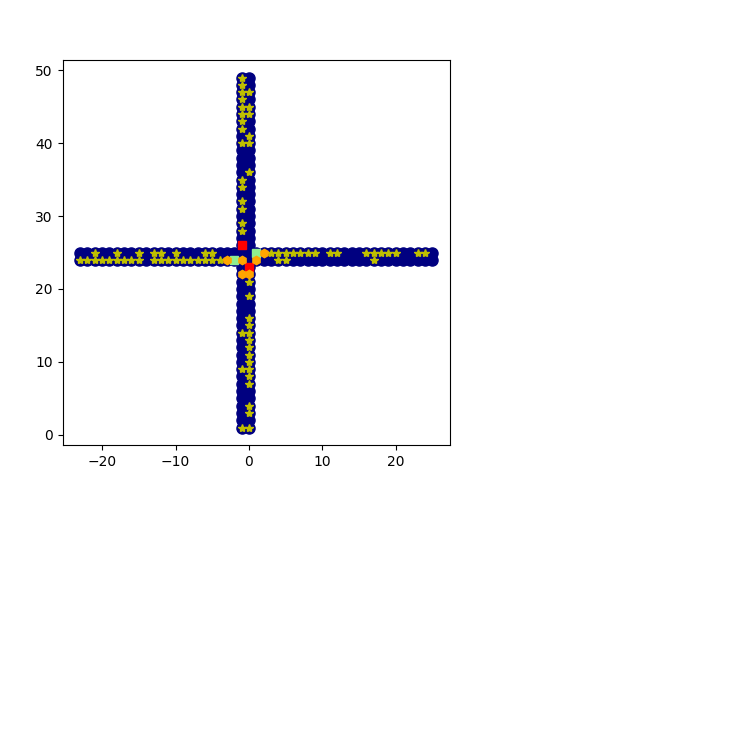

20406080100120140160180200220240260280300

KeyboardInterrupt: 

In [35]:
%matplotlib notebook
TOTAL_TIME = 100
interval = 0.01

fig = plt.figure(figsize =(5,5))
ax = fig.add_subplot(111)
plt.ion()

dist = {'mean':carRateMean.value,'var':carRateVar.value}
SF = City(acciProb=acciProb.value,totalTime=TOTAL_TIME, interval=interval, name = 'SF')
SF.freshMap()
SF.createRoad(direction = (0,1),startPos = (0,1),numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (1,0), startPos = (-int(numOfCell.value/2)+1,int(numOfCell.value/2)), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (0,-1),startPos = (-1,int(numOfCell.value)),numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
SF.createRoad(direction = (-1,0), startPos = (int(numOfCell.value/2)+1,int(numOfCell.value/2)+1), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)
startTime = 0
Stop = False
currentTime = startTime - interval

fig.show()
fig.canvas.draw()

position1 = (-1,int(numOfCell.value/2)+2)
position2 = (1,int(numOfCell.value/2)+1)
position3 = (0,int(numOfCell.value/2)-1)
position4 = (-2,int(numOfCell.value/2))
counter = 0

while not Stop:
    currentTime = currentTime + interval
    if currentTime > TOTAL_TIME:
        Stop = True
    SF.introCar()
    SF.remvCar()
    #SF.moveCar()
    ###########################
    SF.moveCarWithCRA()
    ###########################
    SF.crossRoadLight2(position1, position2, position3, position4, counter)
    SF.showCitySub()
    time.sleep(0.05)
    counter += 1
#     print (len(SF.roads[0].allCars),end=" ")

Then, what if we have many roads? You can decide how many roads we have (However, the roads are randomly generated, don't be fraustrated when the roads are ugly).

In [55]:
numRoads = widgets.IntSlider(value=1,min=1, max=100, step=1, description='numRoads: ')

roadsUI = widgets.VBox([numRoads])

def g(numRoads):
    print('Now we have '+str(numRoads)+ ' roads in our city.')
    return numRoads

roadsOut = widgets.interactive_output(g, {'numRoads': numRoads})

print('Please use the sliders below to adjust the number of roads.')

display(roadsUI, roadsOut)


Please use the sliders below to adjust the number of roads.


Output()

In [36]:
%matplotlib notebook
TOTAL_TIME = 1
interval = 0.01

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

SF = City(acciProb=acciProb.value,totalTime=TOTAL_TIME, interval=interval, name = 'SF')
SF.freshMap()
dist = {'mean':carRateMean.value,'var':carRateVar.value}

for i in range(numRoads.value):
    randDirection = np.random.choice([0,1,-1],size=2)
#     randDirection = np.random.rand(1,2)
#     print(randDirection)
    if (list(randDirection) == [0,1]):
        randStartX = np.random.randint(low=-int(numOfCell.value/2),high=int(numOfCell.value/2))
        randStartY = np.random.randint(low=-int(numOfCell.value/2),high=0)
    elif(list(randDirection) == [1,1]):
        randStartX = np.random.randint(low=-int(numOfCell.value/2),high=0)
        randStartY = np.random.randint(low=-int(numOfCell.value/2),high=0)
    elif(list(randDirection) == [1,0]):
        randStartX = np.random.randint(low=-int(numOfCell.value/2),high=0)
        randStartY = np.random.randint(low=-int(numOfCell.value/2),high=int(numOfCell.value/2))
    elif(list(randDirection) == [0,-1]):
        randStartX = np.random.randint(low=-int(numOfCell.value/2),high=int(numOfCell.value/2))
        randStartY = np.random.randint(low=0,high=int(numOfCell.value/2))
    elif(list(randDirection) == [-1,0]):
        randStartX = np.random.randint(low=0,high=int(numOfCell.value/2))
        randStartY = np.random.randint(low=-int(numOfCell.value/2),high=int(numOfCell.value/2))
    elif(list(randDirection) == [-1,-1]):
        randStartX = np.random.randint(low=0,high=int(numOfCell.value/2))
        randStartY = np.random.randint(low=0,high=int(numOfCell.value/2))
    elif(list(randDirection) == [-1,1]):
        randStartX = np.random.randint(low=0,high=int(numOfCell.value/2))
        randStartY = np.random.randint(low=-int(numOfCell.value/2),high=0)
    elif(list(randDirection) == [1,-1]):
        randStartX = np.random.randint(low=-int(numOfCell.value/2),high=0)
        randStartY = np.random.randint(low=0,high=int(numOfCell.value/2))
    else:
        continue
    SF.createRoad(direction = (randDirection[0],randDirection[1]), startPos = (randStartX,randStartY), numOfCell=numOfCell.value, moveProb=carMoveProb.value, introRate=introRate.value, remvRate=remvRate.value, carRate=dist)

startTime = 0
Stop = False
currentTime = startTime - interval

fig.show()
fig.canvas.draw()

while not Stop:
    currentTime = currentTime + interval
    if currentTime > TOTAL_TIME:
        Stop = True
    SF.introCar()
    SF.remvCar()
    SF.moveCar()
    SF.showCitySub()
    time.sleep(0.05)

<IPython.core.display.Javascript object>

NameError: name 'numRoads' is not defined

# Appendix

In order to show how the average passing cars and car density on the road change w.r.t changes of running time, the dynamic plots are given below.

<IPython.core.display.Javascript object>


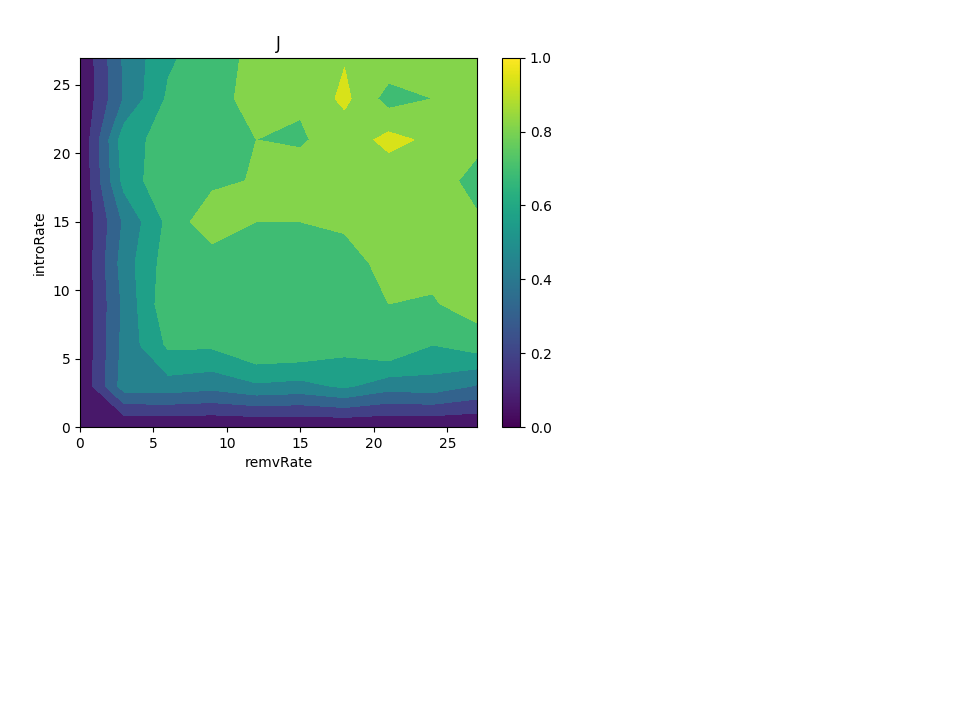

0 0
0
0 3
0
0 6
0
0 9
0
0 12
0
0 15
0
0 18
0
0 21
0
0 24
0
0 27
0
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 0
0
3 3
18
3 6
19
3 9
22
3 12
24
3 15
14
3 18
21
3 21
27
3 24
20
3 27
25
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.8, 1.9, 2.2, 2.4, 1.4, 2.1, 2.7, 2.0, 2.5]]
6 0
0
6 3
23
6 6
31
6 9
30
6 12
31
6 15
30
6 18
32
6 21
31
6 24
35
6 27
30
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.8, 1.9, 2.2, 2.4, 1.4, 2.1, 2.7, 2.0, 2.5], [0.0, 2.3, 3.1, 3.0, 3.1, 3.0, 3.2, 3.1, 3.5, 3.0]]
9 0
0
9 3
17
9 6
29
9 9
34
9 12
35
9 15
30
9 18
37
9 21
37
9 24
37
9 27
37
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.8, 1.9, 2.2, 2.4, 1.4, 2.1, 2.7, 2.0, 2.5], [0.0, 2.3, 3.1, 3.0, 3.1, 3.0, 3.2, 3.1, 3.5, 3.0], [0.0, 1.7, 2.9, 3.4, 3.5, 3.0, 3.7, 3.7, 3.7, 3.7]]
12 0
0
12 3
19
12 6
31
12 9
34
12 12
34
12 15
35
12 18
32
12 21
35
12 24
34
12 27
31
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.8, 1.9, 2.2, 2.4, 1.4, 2.1, 2.7, 2.0, 2

70
9 6
104
9 9
110
9 12
101
9 15
103
9 18
111
9 21
110
9 24
117
9 27
104
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.9666666666666666, 2.1666666666666665, 1.9, 2.2333333333333334, 2.2666666666666666, 2.2333333333333334, 2.533333333333333, 2.3666666666666667, 2.466666666666667], [0.0, 2.1, 3.2333333333333334, 3.1, 3.2666666666666666, 3.3333333333333335, 3.466666666666667, 3.3333333333333335, 3.2333333333333334, 3.3], [0.0, 2.3333333333333335, 3.466666666666667, 3.6666666666666665, 3.3666666666666667, 3.433333333333333, 3.7, 3.6666666666666665, 3.9, 3.466666666666667]]
12 0
0
12 3
59
12 6
103
12 9
112
12 12
113
12 15
113
12 18
111
12 21
117
12 24
110
12 27
107
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.9666666666666666, 2.1666666666666665, 1.9, 2.2333333333333334, 2.2666666666666666, 2.2333333333333334, 2.533333333333333, 2.3666666666666667, 2.466666666666667], [0.0, 2.1, 3.2333333333333334, 3.1, 3.2666666666666666, 3.3333333333333335, 3.466666666666667

KeyboardInterrupt: 

In [26]:
import numpy as np
import matplotlib.pyplot as plt

TOTAL_TIME = 500
interval = 0.01

x = np.arange(0, 30, 3)
y = np.arange(0, 30, 3)
# print("_"*100)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
cb=fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
dist = {'mean':3,'var':0}

for t in range(10,TOTAL_TIME,10):
    j = []
    d = []
    SF = City(acciProb=0,totalTime=t, interval=interval, name = 'SF')
    for ir in x:
        jj = []
        dd = []
        for rr in y:
            SF.freshMap()
            SF.createRoad(numOfCell=10, moveProb=0.5, introRate=ir, remvRate=rr, carRate={'mean':25,'var':5})
            startTime = 0
            Stop = False
            currentTime = startTime - interval
            while not Stop:
                currentTime = currentTime+interval
                if currentTime > t:
                    Stop = True
                SF.introCar()
                SF.remvCar()
                SF.moveCar()
                SF.Time_sum_car()
            SF.calculateRate()
            jj.append(SF.J)
            dd.append(SF.density)
#             print ("|",end="")
        j.append(jj)
        d.append(dd)
        print(j)
    
    ax.clear()
#     cb.remove()
    array_z = np.array(j)
    array_x,array_y = np.meshgrid(x,y)
    surf = ax.contourf(array_x,array_y,array_z)
    plt.xlabel('remvRate')
    plt.ylabel('introRate')
    plt.title("J")
#     ax.colorbar()
#     cb=fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
#     plt.savefig('1roadJ_carRateNormal.png')
#     ax.show()
    fig.canvas.draw()
   
print ('\n\nSimluation Done!')

In [19]:
print (SF)

In [23]:
print(SF.roads[0].allCars)

[]
